# Summary
In Season 12, the strike zone formula is this:
```python
if flinch:
    minroll = 0.5
else:
    minroll = 0.3
strike_max = min(0.90,
                 minroll
                 + 0.35*ruth_scaled*(1 + 0.2*pitcher_vibes)
                 + 0.1*musc_scaled
                 + 0.2*(forwardness - 0.5)
                )
if roll < strike_max:
    strike
else:
    ball
```

In Season 13, the strike zone formula is modified. The The max possible value for a strike goes DOWN from 0.90 to 0.85, and the ruthlessness coefficient goes DOWN from 0.35 to 0.30. This formula holds for Season 13 and Season 14:
```python
if flinch:
    minroll = 0.5
else:
    minroll = 0.3
strike_max = min(0.85,
                 minroll
                 + 0.3*ruth_scaled*(1 + 0.2*pitcher_vibes)
                 + 0.1*musc_scaled
                 + 0.2*(forwardness - 0.5)
                )
if roll < strike_max:
    strike
else:
    ball
```

In Season 15, the strike zone formula changes slightly *again*. The max possible value for a strike goes UP from 0.85 to 0.86, and the ruthlessness coefficient goes DOWN from 0.3 to 0.285 (a 5% decrease):
```python
if flinch:
    minroll = 0.5
else:
    minroll = 0.3
strike_max = min(0.86,
                 minroll
                 + 0.285*ruth_scaled*(1 + 0.2*pitcher_vibes)
                 + 0.1*musc_scaled
                 + 0.2*(forwardness - 0.5)
                )
if roll < strike_max:
    strike
else:
    ball
```


## Load data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
from csv_dtypes import column_dtypes

import load

In [2]:
season = 18
df = load.data("strikes", season=season)

flinch_data = False

df["ruth_vibes"] = load.player_attribute(
    # These values are mandatory: the dataframe, the player role, and the attribute
    df, 'pitcher', 'ruthlessness',
    # These are all optional, and the default values are as they appear here
    vibes=True, mods=True, items=True, broken_items=True
)
df["cold_vibes"] = load.player_attribute(df, 'pitcher', 'coldness', vibes=True, mods=True, items=True, broken_items=True)

df["musc_scaled"] = load.player_attribute(df, 'batter', 'musclitude', vibes=False, mods=True, items=True, broken_items=True)
df["mox_scaled"] = load.player_attribute(df, 'batter', 'moxie', vibes=False, mods=True, items=True, broken_items=True)

# center=True is the default
df["forwardness"] = load.stadium_attribute(df, 'forwardness', center=False)

/Users/robbyblum/opt/anaconda3/envs/py3.9/lib/python3.9/site-packages/dataclasses_json/core.py:171: RuntimeWarning: `NoneType` object value of non-optional type peanut_allergy detected when decoding PlayerData.
  warnings.warn(f"`NoneType` object {warning}.", RuntimeWarning)


In [3]:
df.columns

Index(['event_type', 'event_time', 'roll', 'passed', 'what1', 'what2',
       'batting_team_hype', 'pitching_team_hype', 'game_id', 'play_count',
       'ball_count', 'strike_count', 'out_count', 'home_score', 'away_score',
       'inning', 'baserunner_count', 'baserunners', 'baserunners_next',
       'is_strike', 'strike_roll', 'strike_threshold', 'fielder_roll',
       'batter_consecutive_hits', 'weather', 'season', 'day', 'runner_count',
       'top_of_inning', 'is_maximum_blaseball', 'batter_at_bats',
       'batter_file', 'batting_team_file', 'pitcher_file',
       'pitching_team_file', 'stadium_file', 'fielder_file',
       'relevant_runner_file', 'runner_on_first_file', 'runner_on_second_file',
       'runner_on_third_file', 'runner_on_third_hh_file', 'attacked_team_file',
       'stat_relevant_data', 'pitcher_object', 'batter_object',
       'batting_team_object', 'pitching_team_object', 'stadium_object',
       'pitcher_vibes', 'pitcher_mods', 'pitcher_name', 'batter_vibes',
 

In [4]:
df["ruth_cold"] = (10 * df["ruth_vibes"] + 1 * df["cold_vibes"]) / 11
df["fwd2"] = df["forwardness"] ** 2
df["fwd3"] = df["forwardness"] ** 3
df["mox-musc"] = df["mox_scaled"] - df["musc_scaled"]
df["abs_mox-musc"] = np.abs(df["mox-musc"])
df["hypediff"] = (df["pitching_team_hype"] - df["batting_team_hype"]) * (1 + 0.2 * df["pitcher_vibes"])
df["batting_team_hybes"] = df["batting_team_hype"] * (1 + 0.2 * df["pitcher_vibes"])
df["pitching_team_hybes"] = df["pitching_team_hype"] * (1 + 0.2 * df["pitcher_vibes"])

## Filter data
Handles swapping between flinch and no-flinch situations, and excluding things like ON_FIRE.

In [5]:
# df = df[df["batter_mods"].isna() & df["pitcher_mods"].isna()]
dfc = df.copy()
# dfc["pitcher_mods"] = df.apply(overunder_fix, axis=1)
# dfc = dfc[(dfc["batting_team_hype"] == 0) & (dfc["pitching_team_hype"] == 0)]
# for exclude_mod in ["ON_FIRE", "PSYCHIC", "PARASITE", "MINIMALIST", "MAXIMALIST", "CHUNKY", "SMOOTH", "LATE_TO_PARTY",
#                     "OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
# for exclude_mod in ["ON_FIRE", "PSYCHIC", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
# for exclude_mod in ["ON_FIRE", "PSYCHIC", "PARASITE", "MINIMALIST", "MAXIMALIST"]:
for exclude_mod in ["LATE_TO_PARTY"]:
# for exclude_mod in ["ON_FIRE", "PARASITE", "LATE_TO_PARTY"]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]


for exclude_mod in ["FLINCH"]:
    dfc["flinch"] = (dfc["batter_mods"].astype(str).str.contains(exclude_mod)) & (dfc["strike_count"] == 0)
    print(dfc.groupby("flinch").size())
    if flinch_data:
        dfc = dfc[dfc["flinch"]]
    else:
        dfc = dfc[~dfc["flinch"]]
#     dfc["flinch"] = dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)
# dfc.groupby("flinch").size()

# excluding one weird data point in season 18 that seems incorrect
for exclude_points in [#("080c2816-0fff-4e55-bb9a-8dd547f4e3b1", 41),
                      # ("7d782994-a4fb-469d-9942-e97def670e23", 168),
                      # ("d55e620b-723c-4fb8-acca-41075a8b2823", 345),
                      ]:
    dfc = dfc[~((dfc["game_id"] == exclude_points[0]) & (dfc["play_count"] == exclude_points[1]))]


flinch
False    77609
True      2301
dtype: int64


In [6]:
digest_list = [
    "event_type",
    "roll",
    "threshold",
    "batter_name",
    "pitcher_name",
    "ruth_vibes",
    # "pitcher_vibes",
    "musc_scaled",
    "mox_scaled",
    "ballpark_forwardness",
    "game_id",
    "play_count",
]
# dfc.groupby(["batting_team_mods"]).size()

## SVC fit

In [7]:
# X = dfc[['passed', 'roll', 'ruth_vibes', 'ballpark_forwardness', 'musc_scaled']].copy()
X = dfc[["passed",
         "roll",
         # "ruth_vibes",
         # "cold_vibes",
         "ruth_cold",
         "forwardness",
         # "fwd2",
         # "fwd3",
         # "musc_scaled",
         # "mox_scaled",
         "mox-musc",
         "abs_mox-musc",
         # "batting_team_hybes",
         # "pitching_team_hybes",
         "hypediff",
         ]].copy()
X = X[X["roll"] < 0.86]
X = X[X["forwardness"] > 0.5]
y = X["passed"]
X = X.drop(["passed"], axis=1)

pin_intercept = None
pin_intercept = 0.30
pins = [
    (0.285, "ruth_cold"),
    (0.10, "forwardness"),
    (-0.085, "mox-musc"),
    (-0.035, "abs_mox-musc"),
    # (0.057, "hypediff"),
]
for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:, 0] -= pin_intercept / sc.scale_[0]
    
print(X["roll"].max())
print(X.shape)

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=10000000, fit_intercept=pin_intercept is None,
                           tol=1e-10).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
sc.inverse_transform(trainedsvm.coef_)
trainedsvm.coef_
sc.scale_
trainedsvm.score(X2, y)
print(f"score: {trainedsvm.score(X2, y)} ({len(X2) - sum(np.diag(confusion_matrix(y, predictionsvm)))} outliers)")

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
intercept = trainedsvm.intercept_  # - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept

print(intercept_scaled, ", intercept")
for pair in pins + list(zip(-np.array(coef_list), X.columns)):
    if "roll" not in pair[1]:
        print(pair)

0.9965306913772087
(39763, 2)
[[20139    16]
 [    7 19601]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     20155
        True       1.00      1.00      1.00     19608

    accuracy                           1.00     39763
   macro avg       1.00      1.00      1.00     39763
weighted avg       1.00      1.00      1.00     39763

score: 0.9994215728189523 (23 outliers)
0.3 , intercept
(0.285, 'ruth_cold')
(0.1, 'forwardness')
(-0.085, 'mox-musc')
(-0.035, 'abs_mox-musc')
(0.05808441605359606, 'hypediff')


## Calculate threshold from fit

In [8]:
if flinch_data:
    intercept = 0.50
else:
    intercept = 0.30
if season == 11:
    dfc["threshold"] = (intercept
                        + 0.35 * dfc["ruth_vibes"]
                        + 0.20 * dfc["ballpark_forwardness"]
                        + 0.10 * dfc["musc_scaled"]
                       )
    dfc["svc"] = dfc["threshold"] - intercept
    strikemax = 0.90
    dfc.loc[(dfc["threshold"] > strikemax), "threshold"] = strikemax
elif season == 12 or season == 13:
    dfc["threshold"] = (intercept
                        + 0.30 * dfc["ruth_vibes"]
                        + 0.20 * dfc["ballpark_forwardness"]
                        + 0.10 * dfc["musc_scaled"]
                       )
    dfc["svc"] = dfc["threshold"] - intercept
    strikemax = 0.85
    dfc.loc[(dfc["threshold"] > strikemax), "threshold"] = strikemax
elif season in [14, 15, 16, 17]:
    dfc["threshold"] = (intercept
                        + 0.285 * dfc["ruth_vibes"]
                        + 0.20 * dfc["ballpark_forwardness"]
                        + 0.10 * dfc["musc_scaled"]
                       )
    dfc["svc"] = dfc["threshold"] - intercept
    strikemax = 0.86
    dfc.loc[(dfc["threshold"] > strikemax), "threshold"] = strikemax
elif season == 18:
    intercept = 0.300
    dfc.loc[dfc["forwardness"] > 0.5, "threshold"] = (intercept
                        + 0.285 * dfc["ruth_cold"]
                        + 0.1 * dfc["forwardness"]
                        - 0.085 * dfc["mox-musc"]
                        - 0.035 * dfc["abs_mox-musc"]
                        + 0.058084416053599944 * dfc["hypediff"]
                       )
    dfc.loc[dfc["forwardness"] <= 0.5, "threshold"] = (intercept - 0.05
                        + 0.285 * dfc["ruth_cold"]
                        + 0.2 * dfc["forwardness"]
                        - 0.085 * dfc["mox-musc"]
                        - 0.035 * dfc["abs_mox-musc"]
                        + 0.058084416053599944 * dfc["hypediff"]
                       )
    dfc["svc"] = dfc["threshold"] - intercept
    strikemax = 0.86
    dfc.loc[(dfc["threshold"] > strikemax), "threshold"] = strikemax
else:
    intercept = intercept_scaled
    dfc['threshold'] = intercept_scaled
    print(intercept_scaled)
    for pair in pins + list(zip(-np.array(coef_list), X.columns)):
        if "roll" not in pair[1]:
            print(pair)
            dfc['threshold'] += pair[0] * dfc[pair[1]]
    # dfc['threshold'] += 0.2 * dfc['ballpark_forwardness']
    dfc["svc"] = dfc["threshold"] - intercept_scaled
    strikemax = 0.86
    dfc.loc[(dfc["threshold"] > strikemax), "threshold"] = strikemax

In [9]:
dfc_strikes = dfc[dfc["event_type"] == "StrikeLooking"]
dfc_flinch = dfc[dfc["event_type"] == "StrikeFlinching"]
dfc_balls = dfc[dfc["event_type"] == "Ball"]

## Find Outliers

season
18    30
dtype: int64


,event_type,roll,threshold,offset,batter_name,pitcher_name,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,day,game_id,play_count,weather,ball_count,strike_count,out_count,top_of_inning
24407,Ball,0.252103,0.423641,-0.171539,Bees Taswell,Zephyr McCloud,SOUNDPROOF;SCATTERED;AMBITIOUS,TRIPLE_THREAT,MAINTENANCE_MODE;STALEPOPCORN_PAYOUTS,AAA,68,d55e620b-723c-4fb8-acca-41075a8b2823,355,Weather.BLACK_HOLE,0,0,1,False
19599,Ball,0.839809,0.857117,-0.017308,Simon Haley,Elvis Figueroa,FLINCH,TRIPLE_THREAT,O_NO;A;GOOD_RIDDANCE;TRAVELING,AFFINITY_FOR_CROWS;AA,64,aa55aab8-cb03-4483-b5b9-393060310e76,371,Weather.BIRDS,0,1,2,True
18945,Ball,0.846168,0.857117,-0.010948,Simon Haley,Elvis Figueroa,FLINCH,TRIPLE_THREAT,O_NO;A;GOOD_RIDDANCE;TRAVELING,AFFINITY_FOR_CROWS;AA,64,aa55aab8-cb03-4483-b5b9-393060310e76,150,Weather.BIRDS,1,2,1,True
24408,Ball,0.411693,0.419632,-0.007939,Kelvin Drumsolo,Zephyr McCloud,,TRIPLE_THREAT,MAINTENANCE_MODE;STALEPOPCORN_PAYOUTS,AAA,68,d55e620b-723c-4fb8-acca-41075a8b2823,359,Weather.BLACK_HOLE,0,0,1,False
11505,Ball,0.738361,0.739222,-0.000861,Mint Shupe,Fenry Marlow,UNCERTAIN,,SOUNDPROOF;LOVE;FIREPROOF,SINKING_SHIP;LIFE_OF_PARTY,81,44b809e8-b8f6-471b-89a9-016b22229e85,15,Weather.SALMON,0,0,2,True
36879,Ball,0.682467,0.683176,-0.000709,Liquid Friend,Jan Canberra,EGO1;SCRAMBLED;ATTRACTOR,CHUNKY,,UNDERSEA,12,6922e6a5-44bd-4753-a8e9-23cb0f92a5c8,203,Weather.PEANUTS,0,1,0,True
24116,Ball,0.652136,0.652692,-0.000556,Yeong-Ho Garcia,Greer Gwiffin,UNDERTAKER;ALTERNATE;FRIEND_OF_CROWS,,PSYCHIC,BIRD_SEED,68,f2401694-c403-480b-a726-bf6c661a78f4,235,Weather.SALMON,0,1,2,True
15433,Ball,0.607858,0.608384,-0.000526,Don Mitchell,Fitzgerald Wanderlust,TRAVELING;REVERBERATING,TRAVELING;SQUIDDISH;WILD,SINKING_SHIP;LIFE_OF_PARTY,HOME_FIELD;SHAME_GIVER,84,fe35c944-3d9c-40f2-9d31-d4d28c152154,77,Weather.GLITTER,0,2,0,True
60841,Ball,0.600131,0.600568,-0.000437,Beasley Day,Patchwork Southwick,MINIMALIST,PRO_SKATER,AFFINITY_FOR_CROWS;AA,BOTTOM_DWELLER;BLACKHOLE_PAYOUTS,32,233b91e8-649f-4639-9d26-07da45899fd3,202,Weather.SUN_2,0,0,0,True
91414,Ball,0.703730,0.704042,-0.000311,Blankenship Fischer,Fenry Marlow,INHABITING,,FIREPROOF;PARTY_TIME;UNHOLEY;CARCINIZATION;0,SINKING_SHIP;LIFE_OF_PARTY;PARTY_TIME,93,05c17884-aed3-4f39-b092-d532d12c5a45,241,Weather.FLOODING,0,2,1,True


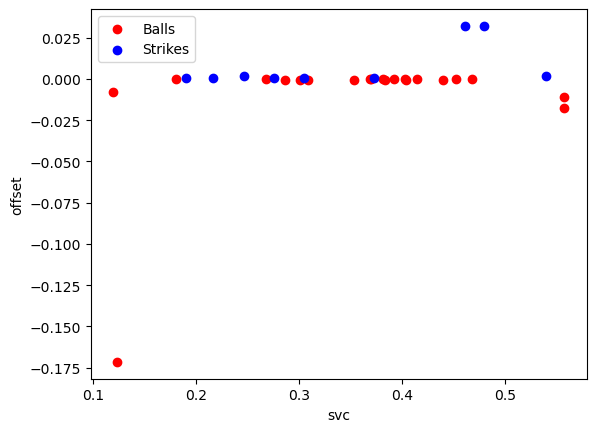

In [16]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]
# outliers = outliers[outliers["forwardness"] < 0.5]

fig, ax = plt.subplots(1)
x_val = "svc"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="Balls",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Strikes",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

table = outliers

# print(outliers.groupby(["batter_mods"]).size().sort_values())
# print(outliers.groupby(["pitcher_mods"]).size().sort_values())
# print(outliers.groupby(["batting_team_mods"]).size().sort_values())
# print(outliers.groupby(["pitching_team_mods"]).size().sort_values())
print(outliers.groupby("season").size())
# pd.set_option("display.max_rows", 10)  # default 60
table[#.loc[#table["pitching_team_mods"].astype(str).str.contains("FIREPROOF"),
    [
        # "home_score", "away_score", "top_of_inning", "inning",
        # "pitcher_mul",
        # "batter_mul",
        "event_type",
        "roll",
        "threshold",
        "offset",
        # "svc",
        # "ruth_vibes",
        # "cold_vibes",
        # "pitcher_ruthlessness",
        # "batter_vibes",
        # "mox_scaled",
        # "musc_scaled",
        # "ballpark_forwardness",
        # "pitcher_coldness",
        # "hypediff",
        "batter_name",
        "pitcher_name",
        "batter_mods",
        "pitcher_mods",
        "batting_team_mods",
        "pitching_team_mods",
        "day",
        "game_id",
        "play_count",
        "weather",
         'ball_count',
         'strike_count',
         'out_count',
        # "baserunner_count",
        # "inning",
        # "home_score",
        # "away_score",
        "top_of_inning",
    ]
].sort_values("offset")#.loc[table["pitcher_mods"].astype(str).str.contains("OVERUNDER"), :]
# pd.set_option("display.max_rows", 60)  # default 60

In [11]:
# plt.plot(np.arange(len(outlier_fraction))/len(outlier_fraction), outlier_fraction.sort_values(), '.-')
# plt.plot(np.arange(len(outlier_fraction_b))/len(outlier_fraction_b), outlier_fraction_b.sort_values(), '.-')
# pd.set_option("display.max_rows", 300)  # default 60
# print(outlier_fraction.sort_values())
# print(outliers_by_pitcher.sort_values())
# print(outlier_fraction_b.sort_values())
pd.set_option("display.max_rows", 60)  # default 60

## Visualize Threshold

Text(0.5, 0.98, 'Season 19, Non-Flinching')

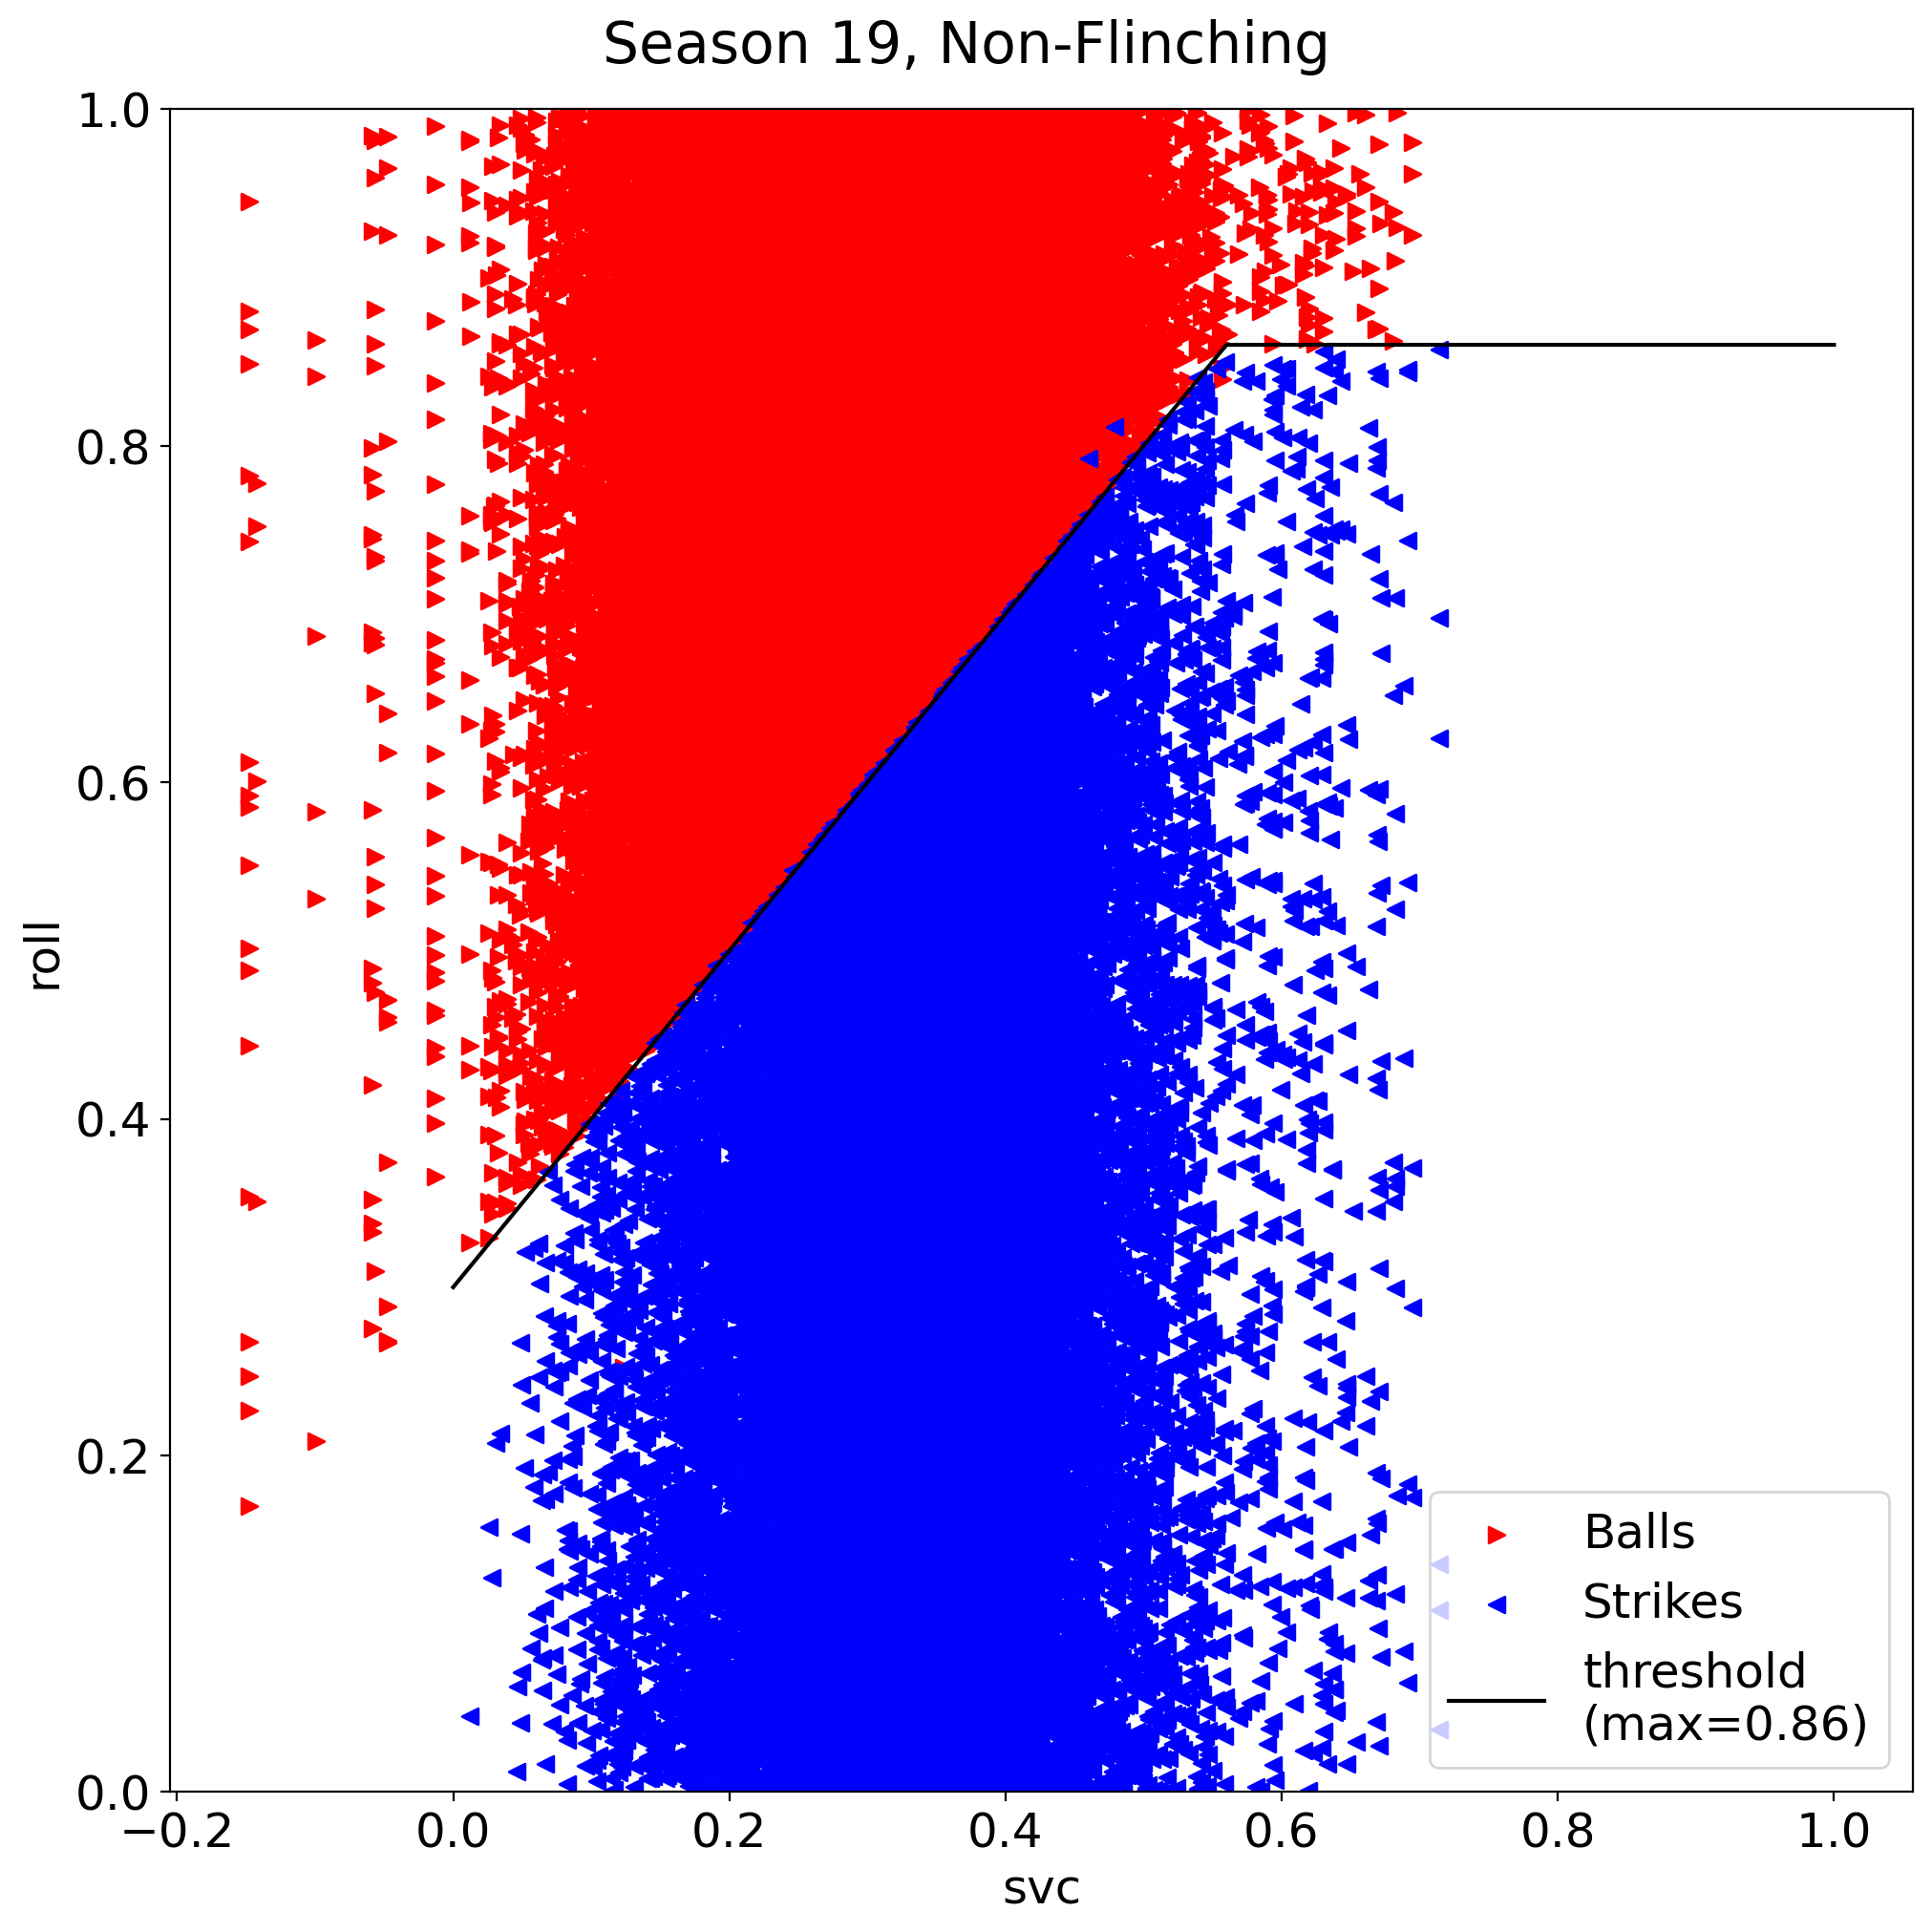

In [12]:
# x_val = "pitcher_ruthlessness"

plt.rcParams["font.size"] = 18
x_val = "svc"
fig, ax = plt.subplots(1, figsize=(10, 10), dpi=200, layout="constrained")

intercept_plot = intercept
# intercept_plot = -intercept_scaled
xline = np.linspace(0, 1, 201)
# xline = np.insert(xline, 1, 0.65)
yline = intercept_plot + xline
# yline = xline
yline[(yline > strikemax)] = strikemax

# ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll"],
    color="red",
    label="Balls",
    marker=">",
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll"],
    color="blue",
    label="Strikes",
    marker="<",
)
# ax.set_xlim(-0.05, 1.05)
ax.plot(xline, yline, "k", label=f"threshold\n(max={strikemax})")
# ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']]["roll"],
#            s=48, edgecolor='black', color="red", label="Balls (below threshold)", marker='<')
# ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["roll"],
#            s=48, edgecolor='black', color="blue", label="Strikes (above threshold)", marker='>')
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
# ax.plot(dfc["svc"].min(), 0.5, 'o')

ax.legend(loc="lower right")
fig.suptitle(f"Season {season+1}, {'' if flinch_data else 'Non-'}Flinching")
# fig.savefig(f"../figures/strikes_s{season+1}{'_flinch' if flinch_data else '_noflinch'}.png",
#             facecolor='white', dpi=200)


In [13]:
outliers.groupby("season").size()

season
18    30
dtype: int64

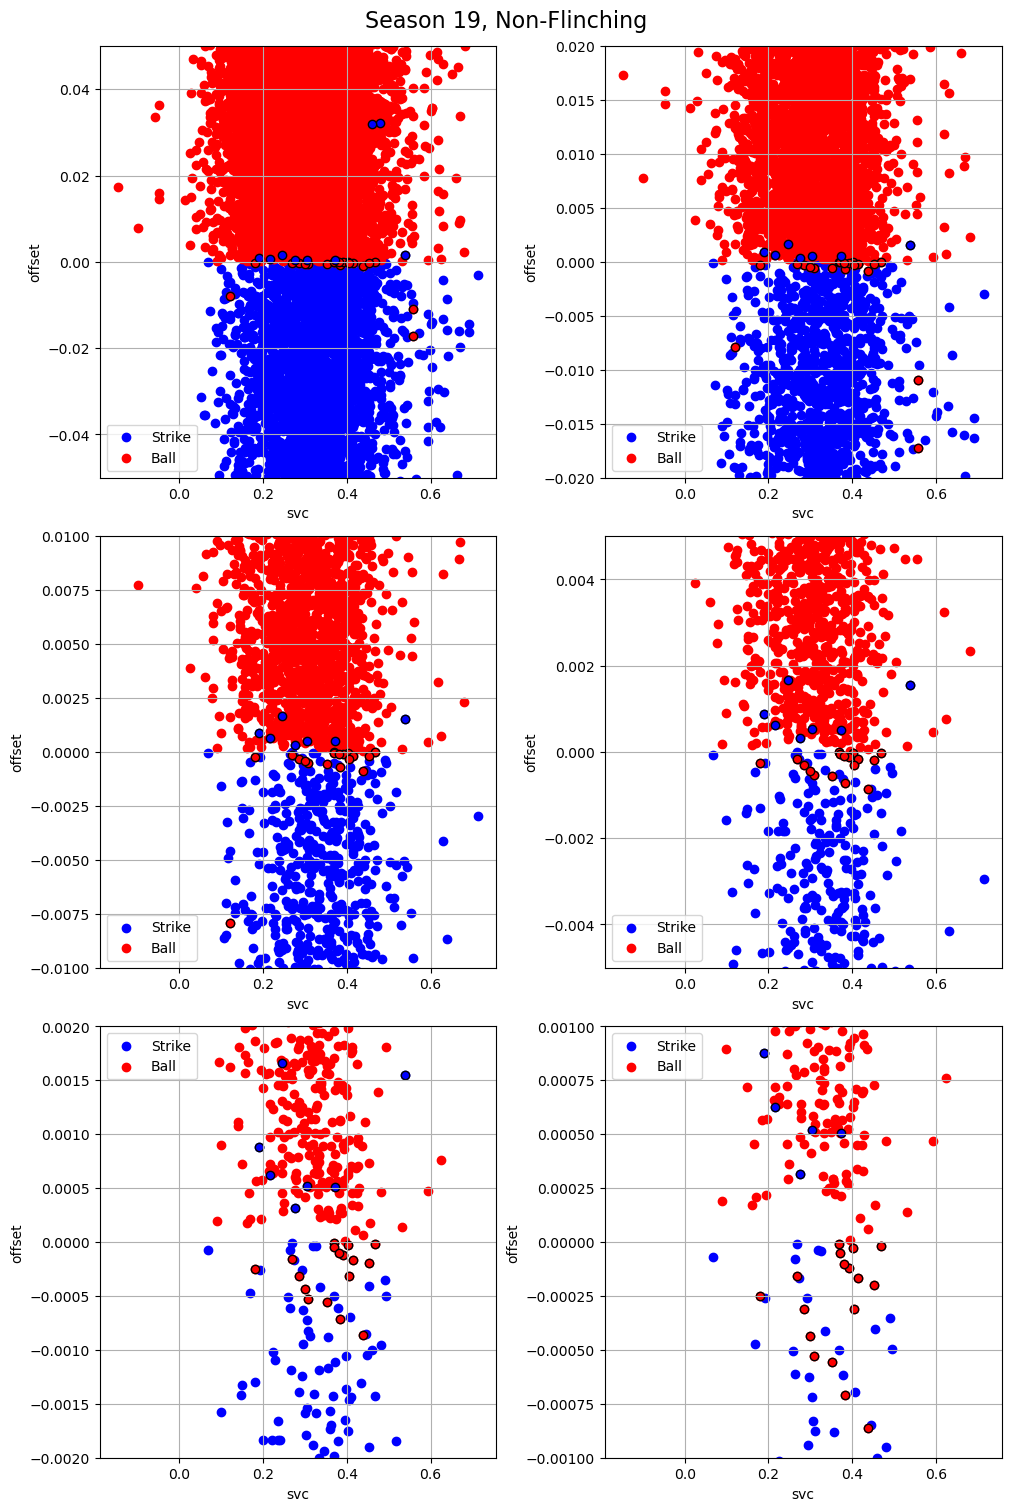

In [14]:
plt.rcParams["font.size"] = 10
x_val = "svc"
fig, axes = plt.subplots(3, 2, figsize=(10, 15), constrained_layout=True)
fig.suptitle(f"Season {season+1}, {'' if flinch_data else 'Non-'}Flinching", fontsize=16)
dimlist = [5e-2, 2e-2, 1e-2, 0.5e-2, 0.2e-2, 0.1e-2]
for i, ax in enumerate(np.ravel(axes)):
    ax.scatter(
        dfc[dfc["passed"]][x_val],
        dfc[dfc["passed"]]["offset"],
        color="blue",
        label="Strike",
    )
    ax.scatter(
        dfc[~dfc["passed"]][x_val],
        dfc[~dfc["passed"]]["offset"],
        color="red",
        label="Ball",
    )
    ax.scatter(
        outliers[~outliers["passed"]][x_val],
        outliers[~outliers["passed"]]["offset"],
        color="red",
        edgecolor="black",
    )
    ax.scatter(
        outliers[outliers["passed"]][x_val],
        outliers[outliers["passed"]]["offset"],
        color="blue",
        edgecolor="black",
    )
    ax.set_xlabel(x_val)
    ax.set_ylabel("offset")
    ax.legend()
    ax.grid()
    ax.set_ylim(-dimlist[i], dimlist[i])
# fig.savefig(f"../figures/ball_strike_fit_offsets_season{season+1}{'_flinch' if flinch_data else '_noflinch'}.png",
#             facecolor='white')


In [15]:
dfc_strikes["roll"].max()

0.8570444062086051